In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import shutil
from keras import layers
from keras import losses
from keras.regularizers import L2
from keras import metrics
from sklearn.metrics import confusion_matrix
import tensorflow_probability as tfp
from keras import optimizers
from keras import models

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/PCOSGen-train/")

In [ ]:
!ls

 class_label.xlsx  'Image Dataset'   images   info.txt


In [ ]:
output_folder = r"/content/drive/My Drive/PCOSGen-train/Image Dataset"
healthy = os.path.join(output_folder, "Healthy")
unhealthy = os.path.join(output_folder, "Unhealthy")

os.makedirs(healthy, exist_ok = True)
os.makedirs(unhealthy, exist_ok = True)

In [ ]:
dataset_path = r"/content/drive/My Drive/PCOSGen-train/class_label.xlsx"
df = pd.read_excel(dataset_path)
df.head()

,imagePath,Healthy
0,100image13.jpg,1
1,100image2.jpg,1
2,100image65.jpg,0
3,100image71.jpg,0
4,100image83.jpg,0


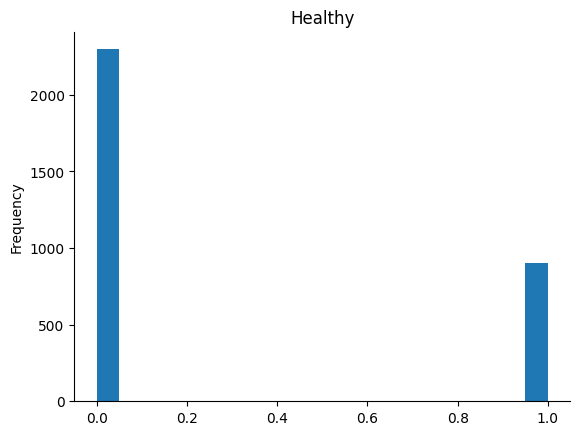

In [ ]:
df['Healthy'].plot(kind='hist', bins=20, title='Healthy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
for index, row in df.iterrows():
  imgPath = row['imagePath']
  label = row['Healthy']

  source_path = os.path.join(r"/content/drive/My Drive/PCOSGen-train/images",imgPath)

  if (label==1):
    dest_path = os.path.join(healthy, imgPath)
  elif (label==0):
    dest_path = os.path.join(unhealthy, imgPath)

  shutil.copyfile(source_path, dest_path)

In [ ]:
directory_path = r"/content/drive/My Drive/PCOSGen-train/Image Dataset"
CLASS_NAMES = ["Healthy", "Unhealthy"]

In [ ]:
training_dataset, valid_dataset = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    class_names = CLASS_NAMES,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'both'
)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Using 640 files for validation.


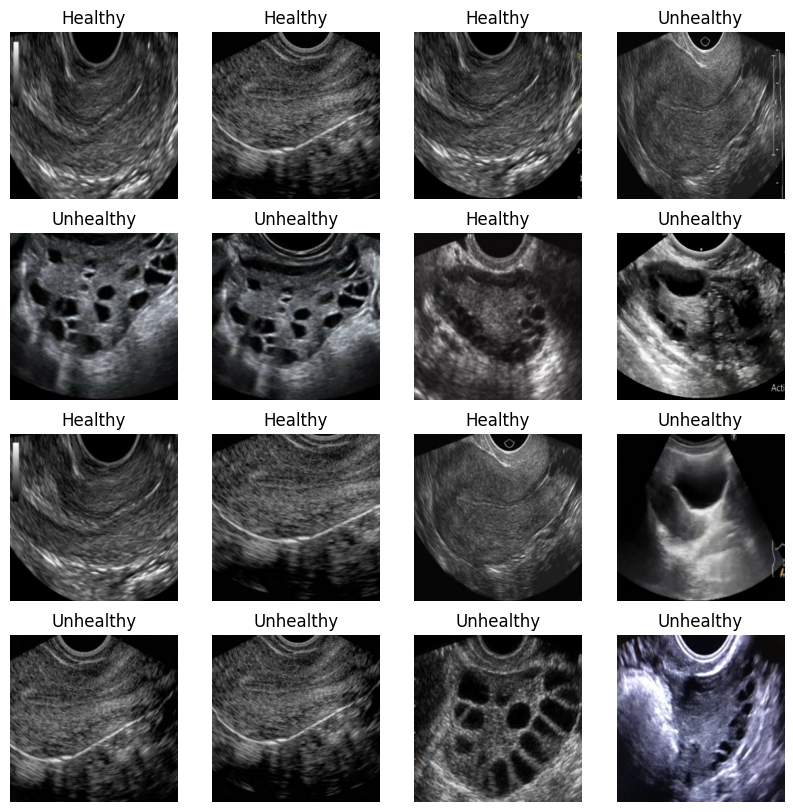

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i].numpy().astype('uint8')[0]])
    plt.axis("off")
plt.show()

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255)
])

In [ ]:
training_dataset = (training_dataset.prefetch(tf.data.AUTOTUNE))
valid_dataset = (valid_dataset.prefetch(tf.data.AUTOTUNE))

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS" : 100,
    "DROPOUT_RATE" : 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 1024,
    "N_DENSE_2" : 128,
    "NUM_CLASSES" : 2
}

In [ ]:
lenet_model = tf.keras.Sequential([
    layers.InputLayer(input_shape = (None,None,3)),
    resize_rescale_layers,

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),
    layers.Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS']*2 + 4, kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),

    layers.Flatten(),
    layers.Dense(CONFIGURATION['N_DENSE_1'], activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    layers.Dense(CONFIGURATION['N_DENSE_2'],activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),

    layers.Dense(1, activation = 'sigmoid')

])

In [ ]:
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
lenet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = lenet_model.fit(training_dataset, epochs = 50, validation_data = valid_dataset, verbose = 1)

NameError: name 'training_dataset' is not defined

In [ ]:
lenet_model.evaluate(valid_dataset)

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()


In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = lenet_model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')


In [ ]:
def prepareLabels(model, dataset):
  y_true = []
  y_pred = []

  for image,label in dataset:
    for i in range(32):
      y_true.append(label[i].numpy().astype('uint8')[0])

  for image, label in dataset:
    for i in range(32):
      value = model.predict(tf.expand_dims(image[i], axis = 0))[0][0]
      if (value>=0.5):
        y_pred.append(1)
      else:
        y_pred.append(0)
  return y_true, y_pred

In [ ]:
def printConfusionMatrix(model,dataset):
  y_true,y_pred = prepareLabels(model, dataset)
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, cmap='Blues')
  plt.colorbar()

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.xticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)
  plt.yticks(np.arange(len(CLASS_NAMES)), CLASS_NAMES)

  for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
      plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

  plt.show()

In [ ]:
printConfusionMatrix(lenet_model, valid_dataset)

NameError: name 'lenet_model' is not defined

Transfer Learning with EfficientNet

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB7(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),
)

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
inception = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256,256,3),
)

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
inception.trainable = False

In [ ]:
backbone.trainable = False

In [ ]:
def inceptionModule_1(x):

  conv_1x1 = layers.Conv2D(6, kernel_size = (1, 1), strides = (1, 1), activation = 'relu')(x)
  conv_3x3 = layers.Conv2D(6, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(conv_1x1)
  conv_5x5 = layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu')(conv_1x1)
  conv_7x7 = layers.Conv2D(6, kernel_size = (7, 7), strides = (1, 1), activation = 'relu')(conv_1x1)

  conv_1x1 = layers.Resizing(256,256)(conv_1x1)
  conv_3x3 = layers.Resizing(256,256)(conv_3x3)
  conv_5x5 = layers.Resizing(256,256)(conv_5x5)
  conv_7x7 = layers.Resizing(256,256)(conv_7x7)

  inceptionModule_1 = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, conv_7x7])

  return inceptionModule_1

In [ ]:
def inceptionModule_2(x):

  conv_3x3 = layers.Conv2D(6, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(x)

  conv_5x5 = layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu')(x)

  conv_7x7 = layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'relu')(x)

  conv_3x3 = layers.Resizing(256,256)(conv_3x3)
  conv_5x5 = layers.Resizing(256,256)(conv_5x5)
  conv_7x7 = layers.Resizing(256,256)(conv_7x7)


  inceptionModule= layers.concatenate([conv_3x3, conv_5x5, conv_7x7])

  return inceptionModule

In [ ]:
inputs = layers.Input(shape = (256,256,3)),
x = backbone(inputs)
# x = resize_rescale_layers(x)
x = layers.BatchNormalization()(x)

x = inceptionModule_1(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = inceptionModule_2(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu')(x)
output = layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = output, name = 'test')

In [ ]:
model.summary()

Model: "test"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 efficientnetb7 (Functional  (None, 8, 8, 2560)           6409768   ['input_3[0][0]']             
 )                                                        7                                       
                                                                                                  
 batch_normalization_203 (B  (None, 8, 8, 2560)           10240     ['efficientnetb7[0][0]']      
 atchNormalization)                                                                               
                                                                                               

In [ ]:
model.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(training_dataset, validation_data = valid_dataset, epochs = 50, verbose = 1)

Epoch 1/50
80/80 [==============================] - 350s 4s/step - loss: 0.6433 - accuracy: 0.6680 - val_loss: 0.5406 - val_accuracy: 0.7297
Epoch 2/50
80/80 [==============================] - 62s 765ms/step - loss: 0.5400 - accuracy: 0.7109 - val_loss: 0.5150 - val_accuracy: 0.7312
Epoch 3/50
80/80 [==============================] - 62s 767ms/step - loss: 0.5117 - accuracy: 0.7359 - val_loss: 0.5012 - val_accuracy: 0.7453
Epoch 4/50
80/80 [==============================] - 63s 773ms/step - loss: 0.4807 - accuracy: 0.7543 - val_loss: 0.4916 - val_accuracy: 0.7547
Epoch 5/50
80/80 [==============================] - 62s 763ms/step - loss: 0.4720 - accuracy: 0.7656 - val_loss: 0.4948 - val_accuracy: 0.7625
Epoch 6/50
80/80 [==============================] - 62s 765ms/step - loss: 0.4582 - accuracy: 0.7629 - val_loss: 0.4672 - val_accuracy: 0.7625
Epoch 7/50
80/80 [==============================] - 62s 765ms/step - loss: 0.4550 - accuracy: 0.7688 - val_loss: 0.4849 - val_accuracy: 0.7563
E

In [ ]:
model.evaluate(valid_dataset)

20/20 [==============================] - 10s 488ms/step - loss: 0.4534 - accuracy: 0.7594


[0.4533935487270355, 0.7593749761581421]

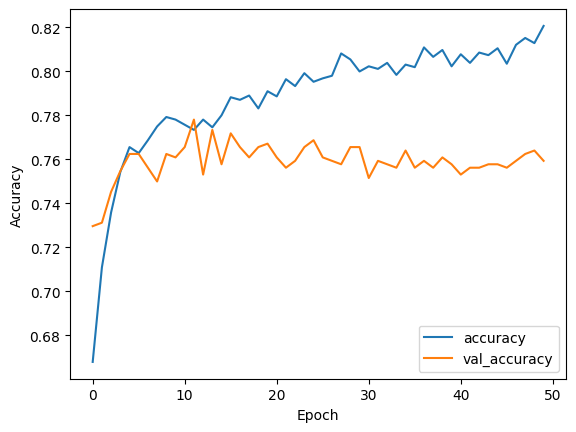

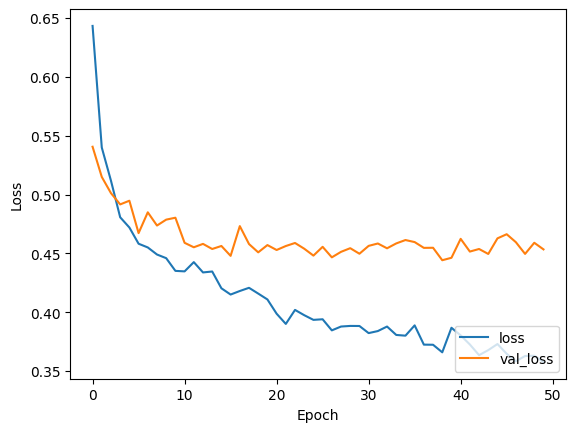

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 43ms/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 32 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

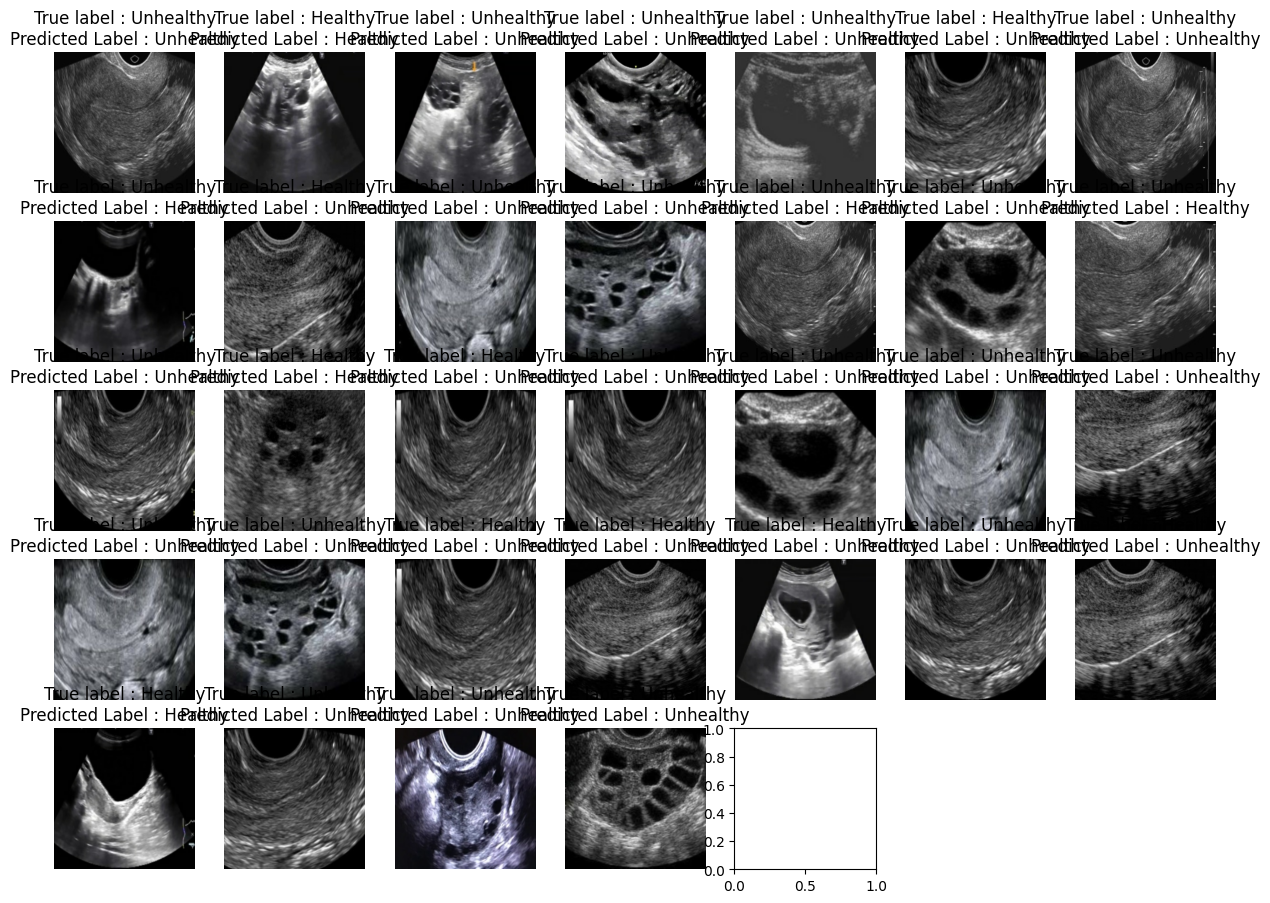

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(4):
  for i in range(49):
    ax = plt.subplot(7,7, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')

1/1 [==============================] - 0s 61ms/step


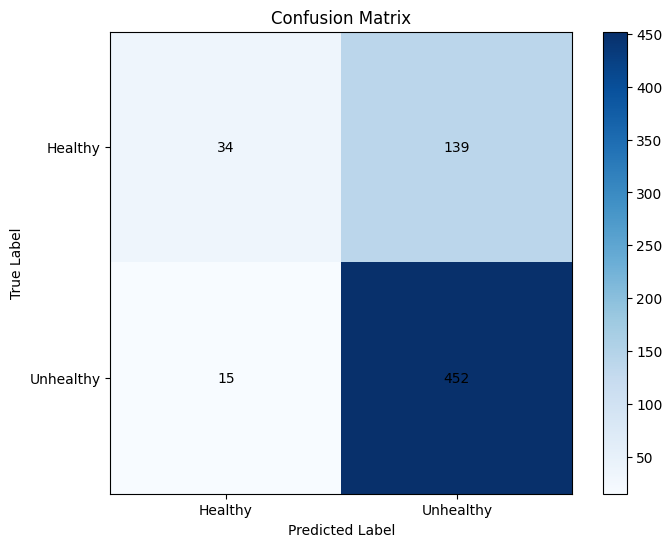

In [ ]:
printConfusionMatrix(model, valid_dataset)

with inception

In [ ]:
inputs = layers.Input(shape = (256,256,3))
x = backbone(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu')(x)
output = layers.Dense(1, activation = 'sigmoid')(x)

model2 = tf.keras.Model(inputs = inputs, outputs = output, name = 'test')

In [ ]:
inputs2 = layers.Input(shape = (256, 256, 3))
x = inception(inputs2)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu')(x)
output2 = layers.Dense(1, activation = 'sigmoid')(x)

model2_inception = tf.keras.Model(inputs = inputs2, outputs = output2, name = 'test2')

In [ ]:
model2_inception.summary()

Model: "test2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, 6, 6, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_206 (B  (None, 6, 6, 1536)        6144      
 atchNormalization)                                              
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 1536)        0         
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                             

In [ ]:
model2.summary()

Model: "test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, 8, 8, 2560)        64097687  
 )                                                               
                                                                 
 batch_normalization_218 (B  (None, 8, 8, 2560)        10240     
 atchNormalization)                                              
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 2560)        0         
                                                                 
 global_average_pooling2d_5  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                              

In [ ]:
second_model = tf.keras.Sequential([
    layers.Input(shape = (256, 256, 3)),
    backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid'),
])

In [ ]:
second_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 8, 8, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_9  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 1024)              2622464   
                                                                 
 batch_normalization_226 (B  (None, 1024)              4096      
 atchNormalization)                                              
                                                                 
 dense_27 (Dense)            (None, 128)               131200    
                                                      

In [ ]:
# second_model.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])
# model2.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])
model2_inception.compile(optimizer = optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history_inception = model2_inception.fit(training_dataset, validation_data = valid_dataset, epochs = 50, verbose = 1)

Epoch 1/50
80/80 [==============================] - 44s 359ms/step - loss: 0.6859 - accuracy: 0.6824 - val_loss: 7.7150 - val_accuracy: 0.2734
Epoch 2/50
80/80 [==============================] - 24s 294ms/step - loss: 0.6119 - accuracy: 0.7105 - val_loss: 0.7732 - val_accuracy: 0.7109
Epoch 3/50
80/80 [==============================] - 24s 288ms/step - loss: 0.5747 - accuracy: 0.7164 - val_loss: 0.5501 - val_accuracy: 0.7078
Epoch 4/50
80/80 [==============================] - 24s 287ms/step - loss: 0.5669 - accuracy: 0.7156 - val_loss: 0.6996 - val_accuracy: 0.6500
Epoch 5/50
80/80 [==============================] - 24s 289ms/step - loss: 0.5601 - accuracy: 0.7176 - val_loss: 0.5892 - val_accuracy: 0.7188
Epoch 6/50
80/80 [==============================] - 24s 288ms/step - loss: 0.5114 - accuracy: 0.7371 - val_loss: 0.5404 - val_accuracy: 0.6875
Epoch 7/50
80/80 [==============================] - 24s 294ms/step - loss: 0.5442 - accuracy: 0.7219 - val_loss: 0.6009 - val_accuracy: 0.6891

In [ ]:
model2_inception.evaluate(valid_dataset)

20/20 [==============================] - 5s 219ms/step - loss: 0.4691 - accuracy: 0.7688


[0.4690946638584137, 0.768750011920929]

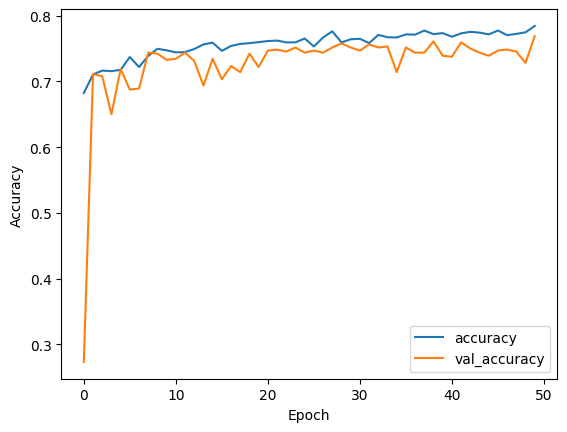

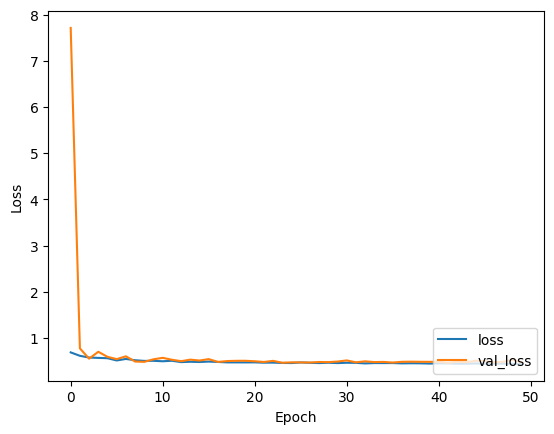

In [ ]:
plt.plot(history_inception.history['accuracy'], label='accuracy')
plt.plot(history_inception.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_inception.history['loss'], label='loss')
plt.plot(history_inception.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 36ms/step


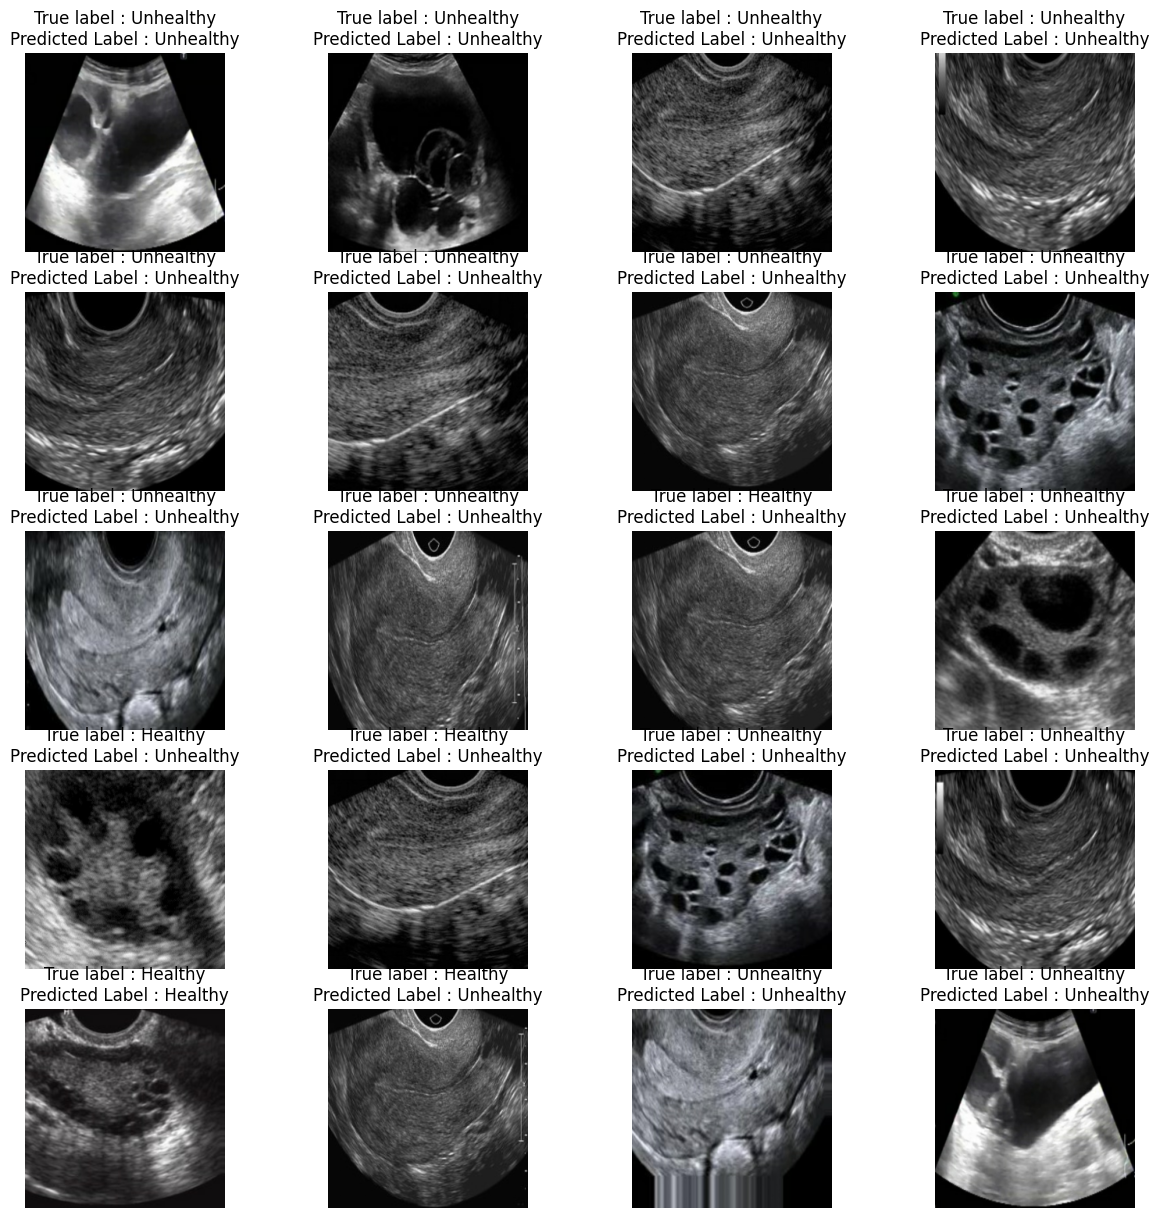

In [ ]:
plt.figure(figsize=(15,15))

for images, labels in valid_dataset.take(5):
  for i in range(20):
    ax = plt.subplot(5,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = model2_inception.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')

1/1 [==============================] - 0s 46ms/step


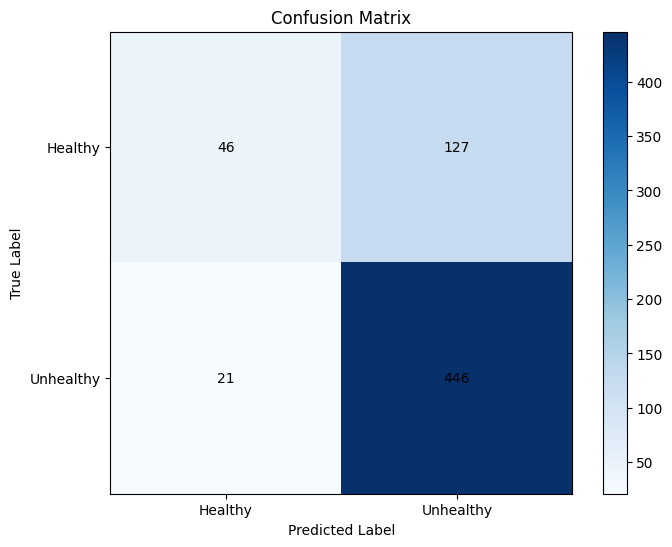

In [ ]:
printConfusionMatrix(model2_inception, valid_dataset)

In [ ]:
history_model2 = model2.fit(training_dataset, validation_data = valid_dataset, epochs = 50, verbose = 1)

Epoch 1/50
80/80 [==============================] - 78s 671ms/step - loss: 0.6480 - accuracy: 0.7070 - val_loss: 0.5304 - val_accuracy: 0.6687
Epoch 2/50
80/80 [==============================] - 48s 588ms/step - loss: 0.4989 - accuracy: 0.7570 - val_loss: 0.5812 - val_accuracy: 0.6266
Epoch 3/50
80/80 [==============================] - 48s 589ms/step - loss: 0.4793 - accuracy: 0.7566 - val_loss: 0.5007 - val_accuracy: 0.7250
Epoch 4/50
80/80 [==============================] - 48s 586ms/step - loss: 0.4496 - accuracy: 0.7625 - val_loss: 0.4552 - val_accuracy: 0.7453
Epoch 5/50
80/80 [==============================] - 48s 589ms/step - loss: 0.4375 - accuracy: 0.7797 - val_loss: 0.4702 - val_accuracy: 0.7406
Epoch 6/50
80/80 [==============================] - 47s 584ms/step - loss: 0.4367 - accuracy: 0.7828 - val_loss: 0.4566 - val_accuracy: 0.7516
Epoch 7/50
80/80 [==============================] - 49s 594ms/step - loss: 0.4255 - accuracy: 0.7793 - val_loss: 0.4728 - val_accuracy: 0.7531

In [ ]:
history_model2_inception = model2_inception.fit(training_dataset, validation_data = valid_dataset, epochs = 50, verbose = 1)